In [90]:
# Import all nessessary modules
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import basinhopping
from pyswarm import pso
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import pandas as pd

eps = 0.001

# setup the plotting parameters
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams["figure.dpi"] = 100
img_dir = "./images/"

In [91]:
# Function for data degeneration
def generate_data(k=1000):
    X = np.array([3*i/1000 for i in range(k)])
    
    f = lambda x: 1/(x**2-3*x+2)
    f_x = map(f, X)
    
    Y = np.zeros(k)
    for i, f_val in enumerate(f_x):
        if abs(f_val) > 100:
            Y[i] = np.sign(f_val)*100 + np.random.normal(0, 1)
        else:
            Y[i] = f_val + np.random.normal(0, 1)
            
    return X, Y

# Rational function for approximation
def minim_poly(x, a, b, c, d):
    return (a*x + b) / (x**2 + c*x + d)

# MSE function to minimize
def mse_loss(params, Y, X, func):
    mse = np.mean((func(X, *params) - Y)**2)
    return mse

# Simulated Annealing

In [92]:
X, Y = generate_data()
init_guess = np.random.uniform(size = 4)

anneal_res = basinhopping(mse_loss, init_guess, T=0.5, minimizer_kwargs={"args": (Y, X, minim_poly)}, niter=1000, niter_success=200)
print(anneal_res)

                        fun: 137.19802020438067
 lowest_optimization_result:       fun: 137.19802020438067
 hess_inv: array([[ 9.83753001e-03, -9.83899960e-03, -1.36379299e-05,
         1.33597122e-05],
       [-9.83899960e-03,  9.84058736e-03,  1.34304552e-05,
        -1.31520116e-05],
       [-1.36379300e-05,  1.34304553e-05,  8.06609859e-07,
        -8.06870148e-07],
       [ 1.33597123e-05, -1.31520117e-05, -8.06870148e-07,
         8.07148524e-07]])
      jac: array([-7.50495911e-01, -7.55140305e-01,  9.23593826e+02,  9.22369335e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1061
      nit: 72
     njev: 175
   status: 2
  success: False
        x: array([-1.00596557,  1.00646214, -2.0009394 ,  1.00095562])
                    message: ['success condition satisfied']
      minimization_failures: 477
                       nfev: 431872
                        nit: 491
                       njev: 71111
                          x: array(

# Swarm optimization

In [93]:
swarm_xopt, swarm_fopt = pso(mse_loss, [-4]*4, [4]*4, args=(Y, X, minim_poly), swarmsize=100, omega=0.7, phip=0.5, phig=0.5, maxiter=1000, minstep=1e-8, minfunc=1e-8, debug=False)
print(f"Found minimum {swarm_fopt} at {swarm_xopt}")

Stopping search: Swarm best objective change less than 1e-08
Found minimum 162.8254399689705 at [-1.81369918  1.81463353 -2.00091446  1.00098592]


# Nelder-Mead

In [75]:
%time NM_res = minimize(mse_loss, init_guess, args=(Y, X, minim_poly), method="Nelder-Mead", tol=eps, options={"maxiter":1000, "adaptive":True})
print(NM_res)

CPU times: user 70.3 ms, sys: 13 µs, total: 70.4 ms
Wall time: 73.8 ms
 final_simplex: (array([[ 0.0372853 , -0.04091422, -2.02301226,  1.02317468],
       [ 0.03726163, -0.04090048, -2.02305012,  1.02321287],
       [ 0.03719674, -0.04087404, -2.02308941,  1.02325334],
       [ 0.03723512, -0.04090341, -2.02298904,  1.02315128],
       [ 0.03713374, -0.04085109, -2.02311191,  1.02327651]]), array([239.1412538 , 239.14129148, 239.14147777, 239.14179774,
       239.14222133]))
           fun: 239.1412538044206
       message: 'Optimization terminated successfully.'
          nfev: 673
           nit: 388
        status: 0
       success: True
             x: array([ 0.0372853 , -0.04091422, -2.02301226,  1.02317468])


# Levenberg-Marquardt

In [94]:
LM_koeffs = curve_fit(minim_poly, X, Y, method="lm")
print(LM_koeffs)

(array([-1.00658988,  1.00706546, -2.00085707,  1.00087328]), array([[ 2.05678360e-03, -2.05757263e-03, -9.07098376e-07,
         8.44855632e-07],
       [-2.05757263e-03,  2.05839938e-03,  8.28680964e-07,
        -7.66424362e-07],
       [-9.07098403e-07,  8.28680992e-07,  3.03563176e-07,
        -3.03479083e-07],
       [ 8.44855659e-07, -7.66424389e-07, -3.03479083e-07,
         3.03398854e-07]]))


# Results

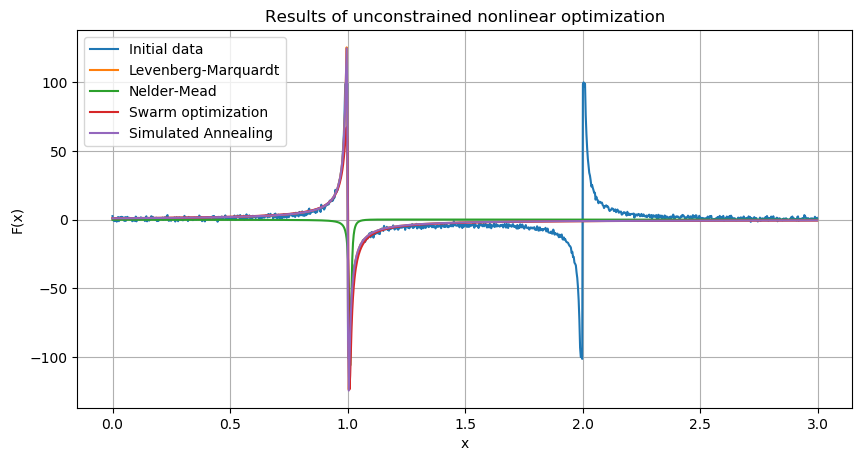

In [78]:
fig, ax = plt.subplots()
plt.grid()


ax.set_xlabel("x")
ax.set_ylabel("F(x)")
ax.set_title(f"Results of unconstrained nonlinear optimization")

plt.plot(X, Y, label="Initial data")

plt.plot(X, minim_poly(X, *LM_koeffs[0]), label="Levenberg-Marquardt" )
plt.plot(X, minim_poly(X, *NM_res.x), label="Nelder-Mead" )
plt.plot(X, minim_poly(X, *swarm_xopt), label="Swarm optimization" )
plt.plot(X, minim_poly(X, *anneal_res.x), label="Simulated Annealing" )

_ = plt.legend(loc="upper left")

plt.savefig(img_dir + "results.png")